# **Generating Covid19 images using Deep convolutional GAN**

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Preparing Dataset

In [2]:
data_dir = './Scheme2(292)-Dataset'
print(data_dir)
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

./Scheme2(292)-Dataset
['test', 'train']
['COVID19', 'PNEUMONIA']


In [3]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose, Resize

dataset = ImageFolder(data_dir+"/train", transform=tt.Compose([tt.ToTensor(), tt.Grayscale(num_output_channels=1), tt.Resize((64,64)), tt.Normalize(mean=(0.5,), std=(0.5,))]))

In [4]:
img, label = dataset[0]
print('Label: ', label)
print('Image Shape: ',img.shape)
print(img[:,10:15,10:15])

torch.min(img), torch.max(img)


Label:  0
Image Shape:  torch.Size([1, 64, 64])
tensor([[[-0.3494, -0.2719, -0.1506, -0.1316, -0.0571],
         [-0.3102, -0.1863, -0.1191,  0.1334,  0.1513],
         [-0.1870, -0.0405, -0.1206,  0.0086,  0.0450],
         [ 0.0842,  0.1875,  0.1476, -0.0028,  0.0502],
         [ 0.1316,  0.1340,  0.3372,  0.3654,  0.3254]]])


(tensor(-1.), tensor(0.8086))

In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

tensor([[[-0.8395, -0.8512, -0.8473,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9333, -0.9398, -0.9373,  ..., -0.9910, -1.0000, -1.0000],
         [-0.9451, -0.9529, -0.9529,  ..., -0.8660, -0.8621, -0.8536],
         ...,
         [-0.1687, -0.2275, -0.3082,  ..., -0.9216, -0.9350, -0.7121],
         [-0.1844, -0.2354, -0.3648,  ..., -0.8888, -0.9308, -0.7269],
         [-0.2024, -0.2877, -0.4533,  ..., -0.9054, -0.9329, -0.8205]]])
Label: 0


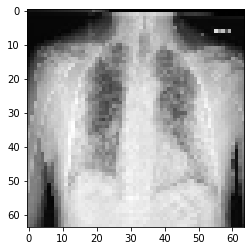

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print(img)
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [7]:
from torch.utils.data import DataLoader

batch_size = 20
data_loader = DataLoader(dataset, batch_size, shuffle=True)

first batch
torch.Size([20, 1, 64, 64])
tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


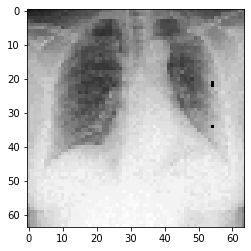

In [8]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

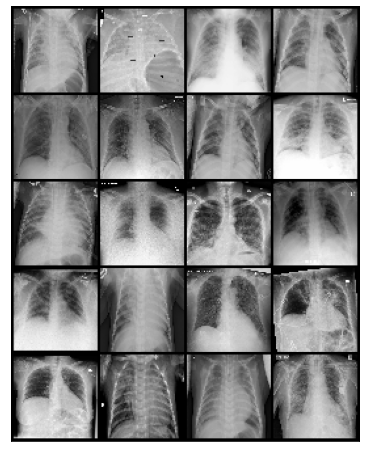

In [10]:
show_batch(data_loader)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
data_loader = DeviceDataLoader(data_loader, device)

# Discriminator Network

In [14]:
import torch.nn as nn

In [ ]:
class SimpleDicriminatorBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=1, stride=1, padding=0, bias=False)#Output: 28 * 14 * 14
        
        #self.bn1 = nn.BatchNorm2d(28),
        #self.relu =nn.LeakyReLU(0.2, inplace=True)
        
        
    def forward(self, x):
        out = self.conv1(x)
        #out = self.bn1(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #return self.relu2(out) + x 
        return out

In [ ]:
simple_discriminator = to_device(SimpleDicriminatorBlock(), device)

for images, labels in data_loader:
    out = simple_discriminator(images)
    print(out.shape)
    
    break
    
del simple_discriminator, images, labels
torch.cuda.empty_cache()

In [15]:
discriminator = nn.Sequential(
    # in: 1 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)

# Generator Network

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

torch.Size([20, 1, 64, 64])


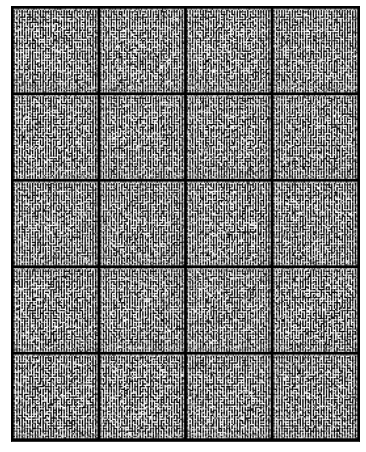

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

# Discriminator Training

In [21]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'WithGrid-XrayImages-Scheme2(292)-DCGAN'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(20, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving fake_images-0000.png


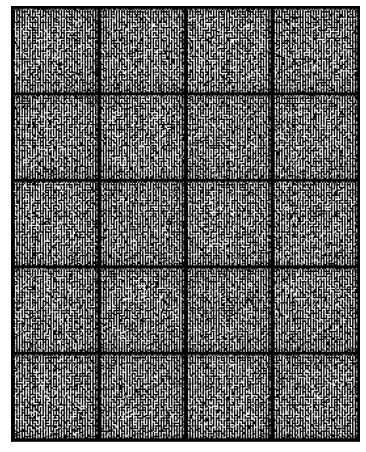

In [27]:
save_samples(0, fixed_latent)

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
epoch_flag = False

In [41]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    if epoch_flag == True:
        previous_epochs = previous_epochs
    elif epoch_flag == False:
        previous_epochs = 0
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(data_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        
        all_epochs = epoch + 1 + previous_epochs
        if epoch_flag == True:
            save_samples(all_epochs,fixed_latent, show=False)
        elif epoch_flag == False:
            save_samples(epoch + 1,fixed_latent, show=False)
        
        
        torch.save({
            'epoch': all_epochs,
            'Gmodel_state_dict': generator.state_dict(),
            'Dmodel_state_dict': discriminator.state_dict(),
            'G_optimizer':opt_g.state_dict(),
            'D_optimizer':opt_d.state_dict()
              
            }, 'DCGAN-COVID19-A-Scheme2(292).pt')     
        
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 300

In [32]:
history = fit(epochs, lr)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 6.0971, loss_d: 0.0357, real_score: 0.9906, fake_score: 0.0258
Saving fake_images-0001.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 6.7738, loss_d: 0.0167, real_score: 0.9927, fake_score: 0.0092
Saving fake_images-0002.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 7.5278, loss_d: 0.0154, real_score: 0.9942, fake_score: 0.0096
Saving fake_images-0003.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 7.5831, loss_d: 0.0057, real_score: 0.9987, fake_score: 0.0043
Saving fake_images-0004.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 7.5033, loss_d: 0.0050, real_score: 0.9972, fake_score: 0.0022
Saving fake_images-0005.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 7.9463, loss_d: 0.0063, real_score: 0.9967, fake_score: 0.0030
Saving fake_images-0006.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 7.9097, loss_d: 0.0029, real_score: 0.9991, fake_score: 0.0019
Saving fake_images-0007.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 7.9874, loss_d: 0.0029, real_score: 0.9991, fake_score: 0.0019
Saving fake_images-0008.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 8.0011, loss_d: 0.0052, real_score: 0.9963, fake_score: 0.0015
Saving fake_images-0009.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 8.2319, loss_d: 0.0045, real_score: 0.9980, fake_score: 0.0024
Saving fake_images-0010.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 8.1824, loss_d: 0.0019, real_score: 0.9997, fake_score: 0.0016
Saving fake_images-0011.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 8.2929, loss_d: 0.0013, real_score: 0.9999, fake_score: 0.0012
Saving fake_images-0012.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 8.2885, loss_d: 0.0010, real_score: 1.0000, fake_score: 0.0009
Saving fake_images-0013.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 8.1441, loss_d: 0.0025, real_score: 0.9987, fake_score: 0.0011
Saving fake_images-0014.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 8.1864, loss_d: 0.0040, real_score: 0.9973, fake_score: 0.0012
Saving fake_images-0015.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 8.3127, loss_d: 0.0013, real_score: 0.9995, fake_score: 0.0008
Saving fake_images-0016.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 8.2996, loss_d: 0.0030, real_score: 0.9979, fake_score: 0.0008
Saving fake_images-0017.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 8.6919, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0009
Saving fake_images-0018.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 10.0950, loss_d: 0.0015, real_score: 0.9999, fake_score: 0.0014
Saving fake_images-0019.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 7.0805, loss_d: 0.2895, real_score: 0.9611, fake_score: 0.2153
Saving fake_images-0020.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 5.5697, loss_d: 0.0729, real_score: 0.9776, fake_score: 0.0475
Saving fake_images-0021.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 5.9667, loss_d: 0.1606, real_score: 0.9267, fake_score: 0.0666
Saving fake_images-0022.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 6.1818, loss_d: 0.0521, real_score: 0.9708, fake_score: 0.0188
Saving fake_images-0023.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 6.0825, loss_d: 0.1524, real_score: 0.9346, fake_score: 0.0681
Saving fake_images-0024.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 5.9546, loss_d: 0.0417, real_score: 0.9990, fake_score: 0.0394
Saving fake_images-0025.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 5.4539, loss_d: 0.0232, real_score: 0.9990, fake_score: 0.0219
Saving fake_images-0026.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 8.8224, loss_d: 0.0734, real_score: 0.9997, fake_score: 0.0700
Saving fake_images-0027.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 6.8693, loss_d: 0.0319, real_score: 0.9804, fake_score: 0.0111
Saving fake_images-0028.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 7.1968, loss_d: 0.0066, real_score: 0.9982, fake_score: 0.0049
Saving fake_images-0029.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 13.5168, loss_d: 0.0697, real_score: 0.9938, fake_score: 0.0610
Saving fake_images-0030.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 18.0126, loss_d: 0.7597, real_score: 0.7973, fake_score: 0.0000
Saving fake_images-0031.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 9.8666, loss_d: 5.4395, real_score: 0.9642, fake_score: 0.9803
Saving fake_images-0032.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 2.6607, loss_d: 0.2881, real_score: 0.8532, fake_score: 0.0935
Saving fake_images-0033.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 3.0492, loss_d: 0.9410, real_score: 0.4574, fake_score: 0.0109
Saving fake_images-0034.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 8.3187, loss_d: 1.3331, real_score: 0.9041, fake_score: 0.6342
Saving fake_images-0035.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 2.4528, loss_d: 0.7282, real_score: 0.7959, fake_score: 0.3549
Saving fake_images-0036.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 2.3197, loss_d: 0.6894, real_score: 0.8104, fake_score: 0.2755
Saving fake_images-0037.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 2.1055, loss_d: 0.8164, real_score: 0.6273, fake_score: 0.1973
Saving fake_images-0038.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 1.7353, loss_d: 1.2284, real_score: 0.3593, fake_score: 0.0641
Saving fake_images-0039.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 1.3660, loss_d: 1.2389, real_score: 0.8143, fake_score: 0.5854
Saving fake_images-0040.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 2.6790, loss_d: 0.2480, real_score: 0.8816, fake_score: 0.1045
Saving fake_images-0041.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 1.7561, loss_d: 1.0590, real_score: 0.9350, fake_score: 0.5986
Saving fake_images-0042.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 1.4347, loss_d: 1.5818, real_score: 0.3152, fake_score: 0.0329
Saving fake_images-0043.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 2.5554, loss_d: 1.4462, real_score: 0.2886, fake_score: 0.0392
Saving fake_images-0044.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 3.8623, loss_d: 0.8443, real_score: 0.5464, fake_score: 0.0138
Saving fake_images-0045.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 2.5834, loss_d: 0.2840, real_score: 0.8212, fake_score: 0.0700
Saving fake_images-0046.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 3.6504, loss_d: 0.4147, real_score: 0.7350, fake_score: 0.0663
Saving fake_images-0047.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 5.1134, loss_d: 0.8380, real_score: 0.9396, fake_score: 0.4953
Saving fake_images-0048.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 2.6227, loss_d: 0.3522, real_score: 0.8013, fake_score: 0.0998
Saving fake_images-0049.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 2.6310, loss_d: 0.6473, real_score: 0.6514, fake_score: 0.1252
Saving fake_images-0050.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 3.3569, loss_d: 0.6861, real_score: 0.6124, fake_score: 0.0163
Saving fake_images-0051.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [52/300], loss_g: 3.3899, loss_d: 0.7135, real_score: 0.8609, fake_score: 0.3649
Saving fake_images-0052.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [53/300], loss_g: 1.3730, loss_d: 0.7560, real_score: 0.6411, fake_score: 0.1687
Saving fake_images-0053.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [54/300], loss_g: 3.4483, loss_d: 0.2744, real_score: 0.8266, fake_score: 0.0654
Saving fake_images-0054.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [55/300], loss_g: 5.3253, loss_d: 0.6901, real_score: 0.9505, fake_score: 0.3569
Saving fake_images-0055.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [56/300], loss_g: 1.6914, loss_d: 0.9434, real_score: 0.5304, fake_score: 0.0589
Saving fake_images-0056.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [57/300], loss_g: 2.8486, loss_d: 1.0142, real_score: 0.5289, fake_score: 0.2051
Saving fake_images-0057.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [58/300], loss_g: 3.3832, loss_d: 0.5051, real_score: 0.8693, fake_score: 0.2756
Saving fake_images-0058.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [59/300], loss_g: 5.0294, loss_d: 0.5714, real_score: 0.9248, fake_score: 0.3433
Saving fake_images-0059.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [60/300], loss_g: 1.7649, loss_d: 0.8125, real_score: 0.7741, fake_score: 0.3213
Saving fake_images-0060.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [61/300], loss_g: 2.6139, loss_d: 0.4209, real_score: 0.8687, fake_score: 0.2149
Saving fake_images-0061.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [62/300], loss_g: 1.9695, loss_d: 1.1236, real_score: 0.4919, fake_score: 0.1256
Saving fake_images-0062.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [63/300], loss_g: 1.6153, loss_d: 0.6510, real_score: 0.6446, fake_score: 0.1233
Saving fake_images-0063.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [64/300], loss_g: 3.3767, loss_d: 0.6617, real_score: 0.8619, fake_score: 0.3372
Saving fake_images-0064.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [65/300], loss_g: 3.4549, loss_d: 0.3865, real_score: 0.8061, fake_score: 0.1405
Saving fake_images-0065.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [66/300], loss_g: 5.2119, loss_d: 0.2440, real_score: 0.9379, fake_score: 0.1157
Saving fake_images-0066.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [67/300], loss_g: 2.4769, loss_d: 0.6595, real_score: 0.6217, fake_score: 0.0327
Saving fake_images-0067.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [68/300], loss_g: 1.9550, loss_d: 0.3981, real_score: 0.8036, fake_score: 0.1316
Saving fake_images-0068.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [69/300], loss_g: 2.3357, loss_d: 0.9681, real_score: 0.4892, fake_score: 0.0508
Saving fake_images-0069.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [70/300], loss_g: 3.4728, loss_d: 0.2283, real_score: 0.9032, fake_score: 0.1064
Saving fake_images-0070.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [71/300], loss_g: 4.1188, loss_d: 0.5196, real_score: 0.8549, fake_score: 0.2723
Saving fake_images-0071.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [72/300], loss_g: 4.8422, loss_d: 1.0812, real_score: 0.8487, fake_score: 0.5082
Saving fake_images-0072.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [73/300], loss_g: 4.3537, loss_d: 0.5972, real_score: 0.8427, fake_score: 0.3040
Saving fake_images-0073.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [74/300], loss_g: 5.4362, loss_d: 0.2610, real_score: 0.8034, fake_score: 0.0082
Saving fake_images-0074.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [75/300], loss_g: 5.2194, loss_d: 0.6173, real_score: 0.6671, fake_score: 0.0246
Saving fake_images-0075.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [76/300], loss_g: 2.5589, loss_d: 0.7956, real_score: 0.5608, fake_score: 0.0394
Saving fake_images-0076.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [77/300], loss_g: 3.0494, loss_d: 0.4320, real_score: 0.9599, fake_score: 0.3029
Saving fake_images-0077.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [78/300], loss_g: 3.4360, loss_d: 0.2644, real_score: 0.8565, fake_score: 0.0616
Saving fake_images-0078.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [79/300], loss_g: 1.1707, loss_d: 0.8997, real_score: 0.4957, fake_score: 0.0819
Saving fake_images-0079.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [80/300], loss_g: 3.7477, loss_d: 0.4375, real_score: 0.7773, fake_score: 0.1263
Saving fake_images-0080.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [81/300], loss_g: 2.9943, loss_d: 0.3371, real_score: 0.8828, fake_score: 0.1540
Saving fake_images-0081.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [82/300], loss_g: 3.2064, loss_d: 0.7551, real_score: 0.5329, fake_score: 0.0177
Saving fake_images-0082.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [83/300], loss_g: 4.4908, loss_d: 0.2331, real_score: 0.9021, fake_score: 0.1100
Saving fake_images-0083.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [84/300], loss_g: 3.8000, loss_d: 0.5339, real_score: 0.6750, fake_score: 0.0523
Saving fake_images-0084.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [85/300], loss_g: 2.3802, loss_d: 0.4325, real_score: 0.7289, fake_score: 0.0498
Saving fake_images-0085.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [86/300], loss_g: 3.6060, loss_d: 0.2092, real_score: 0.9220, fake_score: 0.1070
Saving fake_images-0086.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [87/300], loss_g: 4.1391, loss_d: 0.3155, real_score: 0.7942, fake_score: 0.0576
Saving fake_images-0087.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [88/300], loss_g: 5.9146, loss_d: 0.4361, real_score: 0.9731, fake_score: 0.3022
Saving fake_images-0088.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [89/300], loss_g: 3.4204, loss_d: 0.3030, real_score: 0.8950, fake_score: 0.1046
Saving fake_images-0089.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [90/300], loss_g: 3.4741, loss_d: 0.4720, real_score: 0.7421, fake_score: 0.0886
Saving fake_images-0090.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [91/300], loss_g: 2.9397, loss_d: 0.3444, real_score: 0.8322, fake_score: 0.1187
Saving fake_images-0091.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [92/300], loss_g: 4.5881, loss_d: 0.0712, real_score: 0.9979, fake_score: 0.0612
Saving fake_images-0092.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [93/300], loss_g: 5.3134, loss_d: 0.5077, real_score: 0.7956, fake_score: 0.1716
Saving fake_images-0093.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [94/300], loss_g: 3.3933, loss_d: 1.0760, real_score: 0.4344, fake_score: 0.0050
Saving fake_images-0094.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [95/300], loss_g: 5.9022, loss_d: 0.4109, real_score: 0.9855, fake_score: 0.3024
Saving fake_images-0095.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [96/300], loss_g: 4.9592, loss_d: 0.5439, real_score: 0.8726, fake_score: 0.2914
Saving fake_images-0096.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [97/300], loss_g: 3.0329, loss_d: 0.9621, real_score: 0.6427, fake_score: 0.1009
Saving fake_images-0097.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [98/300], loss_g: 5.5744, loss_d: 0.1733, real_score: 0.9682, fake_score: 0.1015
Saving fake_images-0098.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [99/300], loss_g: 2.4674, loss_d: 0.5178, real_score: 0.7289, fake_score: 0.1247
Saving fake_images-0099.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [100/300], loss_g: 4.7044, loss_d: 0.8152, real_score: 0.6877, fake_score: 0.2889
Saving fake_images-0100.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [101/300], loss_g: 3.7661, loss_d: 0.1690, real_score: 0.9283, fake_score: 0.0768
Saving fake_images-0101.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [102/300], loss_g: 4.4609, loss_d: 0.4116, real_score: 0.7936, fake_score: 0.0496
Saving fake_images-0102.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [103/300], loss_g: 3.9166, loss_d: 0.0735, real_score: 0.9808, fake_score: 0.0517
Saving fake_images-0103.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [104/300], loss_g: 3.9378, loss_d: 0.3327, real_score: 0.8037, fake_score: 0.0755
Saving fake_images-0104.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [105/300], loss_g: 2.7652, loss_d: 0.5722, real_score: 0.6860, fake_score: 0.1095
Saving fake_images-0105.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [106/300], loss_g: 3.3206, loss_d: 0.2569, real_score: 0.8566, fake_score: 0.0677
Saving fake_images-0106.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [107/300], loss_g: 5.5541, loss_d: 0.3954, real_score: 0.9697, fake_score: 0.2580
Saving fake_images-0107.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [108/300], loss_g: 3.8099, loss_d: 0.1262, real_score: 0.9219, fake_score: 0.0406
Saving fake_images-0108.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [109/300], loss_g: 0.9319, loss_d: 1.1872, real_score: 0.4784, fake_score: 0.0247
Saving fake_images-0109.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [110/300], loss_g: 3.3239, loss_d: 0.2343, real_score: 0.8471, fake_score: 0.0485
Saving fake_images-0110.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [111/300], loss_g: 3.1563, loss_d: 0.3619, real_score: 0.7977, fake_score: 0.0437
Saving fake_images-0111.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [112/300], loss_g: 4.5633, loss_d: 0.3024, real_score: 0.8453, fake_score: 0.0523
Saving fake_images-0112.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [113/300], loss_g: 7.1437, loss_d: 0.0252, real_score: 0.9913, fake_score: 0.0160
Saving fake_images-0113.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [114/300], loss_g: 6.1134, loss_d: 0.0614, real_score: 0.9922, fake_score: 0.0492
Saving fake_images-0114.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [115/300], loss_g: 6.8004, loss_d: 0.1985, real_score: 0.8638, fake_score: 0.0201
Saving fake_images-0115.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [116/300], loss_g: 4.7818, loss_d: 0.2586, real_score: 0.9025, fake_score: 0.1266
Saving fake_images-0116.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [117/300], loss_g: 4.6176, loss_d: 0.1213, real_score: 0.9654, fake_score: 0.0776
Saving fake_images-0117.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [118/300], loss_g: 2.1077, loss_d: 0.7490, real_score: 0.5360, fake_score: 0.0026
Saving fake_images-0118.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [119/300], loss_g: 3.2111, loss_d: 0.1894, real_score: 0.8596, fake_score: 0.0292
Saving fake_images-0119.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [120/300], loss_g: 3.2318, loss_d: 0.3080, real_score: 0.9961, fake_score: 0.1865
Saving fake_images-0120.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [121/300], loss_g: 5.2483, loss_d: 0.1224, real_score: 0.9435, fake_score: 0.0590
Saving fake_images-0121.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [122/300], loss_g: 4.8963, loss_d: 0.1421, real_score: 0.8811, fake_score: 0.0105
Saving fake_images-0122.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [123/300], loss_g: 3.3177, loss_d: 0.2276, real_score: 0.8602, fake_score: 0.0608
Saving fake_images-0123.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [124/300], loss_g: 1.4324, loss_d: 0.6930, real_score: 0.6078, fake_score: 0.0351
Saving fake_images-0124.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [125/300], loss_g: 3.9922, loss_d: 0.3428, real_score: 0.8671, fake_score: 0.1501
Saving fake_images-0125.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [126/300], loss_g: 5.2739, loss_d: 0.0876, real_score: 0.9443, fake_score: 0.0225
Saving fake_images-0126.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [127/300], loss_g: 4.3864, loss_d: 0.0992, real_score: 0.9206, fake_score: 0.0129
Saving fake_images-0127.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [128/300], loss_g: 5.0526, loss_d: 0.1322, real_score: 0.9990, fake_score: 0.1126
Saving fake_images-0128.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [129/300], loss_g: 2.0803, loss_d: 0.5600, real_score: 0.6470, fake_score: 0.0168
Saving fake_images-0129.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [130/300], loss_g: 4.7775, loss_d: 0.1511, real_score: 0.9064, fake_score: 0.0301
Saving fake_images-0130.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [131/300], loss_g: 4.5785, loss_d: 0.2545, real_score: 0.9473, fake_score: 0.1530
Saving fake_images-0131.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [132/300], loss_g: 6.8234, loss_d: 0.2004, real_score: 0.9516, fake_score: 0.1205
Saving fake_images-0132.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [133/300], loss_g: 6.4661, loss_d: 0.5925, real_score: 0.9804, fake_score: 0.3598
Saving fake_images-0133.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [134/300], loss_g: 4.6606, loss_d: 0.1155, real_score: 0.9115, fake_score: 0.0088
Saving fake_images-0134.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [135/300], loss_g: 6.8091, loss_d: 0.0782, real_score: 0.9916, fake_score: 0.0644
Saving fake_images-0135.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [136/300], loss_g: 4.2277, loss_d: 0.1290, real_score: 0.9214, fake_score: 0.0223
Saving fake_images-0136.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [137/300], loss_g: 3.9594, loss_d: 0.2258, real_score: 0.8707, fake_score: 0.0675
Saving fake_images-0137.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [138/300], loss_g: 0.6206, loss_d: 1.0248, real_score: 0.5011, fake_score: 0.0293
Saving fake_images-0138.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [139/300], loss_g: 5.5991, loss_d: 0.0694, real_score: 0.9901, fake_score: 0.0540
Saving fake_images-0139.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [140/300], loss_g: 3.9728, loss_d: 0.1016, real_score: 0.9893, fake_score: 0.0839
Saving fake_images-0140.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [141/300], loss_g: 5.5743, loss_d: 0.2227, real_score: 0.9472, fake_score: 0.1349
Saving fake_images-0141.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [142/300], loss_g: 6.0843, loss_d: 0.5294, real_score: 0.9904, fake_score: 0.3542
Saving fake_images-0142.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [143/300], loss_g: 2.9873, loss_d: 0.5984, real_score: 0.6486, fake_score: 0.0143
Saving fake_images-0143.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [144/300], loss_g: 6.3773, loss_d: 0.5102, real_score: 0.9787, fake_score: 0.3444
Saving fake_images-0144.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [145/300], loss_g: 6.8762, loss_d: 0.5534, real_score: 0.8200, fake_score: 0.2044
Saving fake_images-0145.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [146/300], loss_g: 5.3827, loss_d: 0.1885, real_score: 0.9908, fake_score: 0.1427
Saving fake_images-0146.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [147/300], loss_g: 4.2544, loss_d: 0.2096, real_score: 0.8696, fake_score: 0.0290
Saving fake_images-0147.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [148/300], loss_g: 4.9307, loss_d: 0.0617, real_score: 0.9674, fake_score: 0.0256
Saving fake_images-0148.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [149/300], loss_g: 3.4196, loss_d: 0.1557, real_score: 0.9124, fake_score: 0.0156
Saving fake_images-0149.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [150/300], loss_g: 4.2350, loss_d: 0.4354, real_score: 0.7502, fake_score: 0.0085
Saving fake_images-0150.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [151/300], loss_g: 6.4274, loss_d: 0.0478, real_score: 0.9926, fake_score: 0.0381
Saving fake_images-0151.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [152/300], loss_g: 5.0942, loss_d: 0.0493, real_score: 0.9964, fake_score: 0.0426
Saving fake_images-0152.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [153/300], loss_g: 5.7134, loss_d: 0.0550, real_score: 0.9934, fake_score: 0.0433
Saving fake_images-0153.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [154/300], loss_g: 4.7067, loss_d: 0.2805, real_score: 0.8047, fake_score: 0.0221
Saving fake_images-0154.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [155/300], loss_g: 6.7153, loss_d: 0.0210, real_score: 0.9936, fake_score: 0.0140
Saving fake_images-0155.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [156/300], loss_g: 7.8857, loss_d: 0.1292, real_score: 0.9856, fake_score: 0.0947
Saving fake_images-0156.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [157/300], loss_g: 7.2994, loss_d: 0.0408, real_score: 0.9878, fake_score: 0.0271
Saving fake_images-0157.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [158/300], loss_g: 8.4007, loss_d: 0.3847, real_score: 0.8173, fake_score: 0.0029
Saving fake_images-0158.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [159/300], loss_g: 5.7828, loss_d: 0.2623, real_score: 0.9835, fake_score: 0.1868
Saving fake_images-0159.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [160/300], loss_g: 6.8469, loss_d: 0.2151, real_score: 0.9867, fake_score: 0.1270
Saving fake_images-0160.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [161/300], loss_g: 6.8027, loss_d: 0.3971, real_score: 0.9192, fake_score: 0.2315
Saving fake_images-0161.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [162/300], loss_g: 1.7695, loss_d: 0.6848, real_score: 0.6956, fake_score: 0.0198
Saving fake_images-0162.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [163/300], loss_g: 4.6887, loss_d: 0.3528, real_score: 0.8045, fake_score: 0.0412
Saving fake_images-0163.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [164/300], loss_g: 6.4718, loss_d: 0.0532, real_score: 0.9779, fake_score: 0.0291
Saving fake_images-0164.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [165/300], loss_g: 5.1544, loss_d: 0.0328, real_score: 0.9905, fake_score: 0.0225
Saving fake_images-0165.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [166/300], loss_g: 4.4396, loss_d: 0.5070, real_score: 0.7461, fake_score: 0.0243
Saving fake_images-0166.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [167/300], loss_g: 4.8607, loss_d: 0.4083, real_score: 0.7709, fake_score: 0.0239
Saving fake_images-0167.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [168/300], loss_g: 4.2425, loss_d: 0.1599, real_score: 0.9220, fake_score: 0.0366
Saving fake_images-0168.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [169/300], loss_g: 8.3173, loss_d: 0.3884, real_score: 0.9891, fake_score: 0.2458
Saving fake_images-0169.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [170/300], loss_g: 7.0508, loss_d: 0.8237, real_score: 0.5614, fake_score: 0.0011
Saving fake_images-0170.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [171/300], loss_g: 6.7221, loss_d: 0.3081, real_score: 0.9600, fake_score: 0.1579
Saving fake_images-0171.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [172/300], loss_g: 4.8070, loss_d: 0.0911, real_score: 0.9892, fake_score: 0.0729
Saving fake_images-0172.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [173/300], loss_g: 4.8346, loss_d: 0.4802, real_score: 0.6645, fake_score: 0.0036
Saving fake_images-0173.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [174/300], loss_g: 5.0363, loss_d: 0.0786, real_score: 0.9929, fake_score: 0.0631
Saving fake_images-0174.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [175/300], loss_g: 7.0368, loss_d: 0.1250, real_score: 0.8914, fake_score: 0.0018
Saving fake_images-0175.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [176/300], loss_g: 4.6964, loss_d: 0.1249, real_score: 0.9720, fake_score: 0.0864
Saving fake_images-0176.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [177/300], loss_g: 4.4826, loss_d: 0.4496, real_score: 0.8065, fake_score: 0.0622
Saving fake_images-0177.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [178/300], loss_g: 4.7742, loss_d: 0.1479, real_score: 0.9224, fake_score: 0.0570
Saving fake_images-0178.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [179/300], loss_g: 6.4580, loss_d: 0.3211, real_score: 0.8780, fake_score: 0.0657
Saving fake_images-0179.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [180/300], loss_g: 7.9853, loss_d: 0.1089, real_score: 0.9162, fake_score: 0.0098
Saving fake_images-0180.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [181/300], loss_g: 6.9858, loss_d: 0.0233, real_score: 0.9889, fake_score: 0.0118
Saving fake_images-0181.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [182/300], loss_g: 4.9710, loss_d: 0.0580, real_score: 0.9969, fake_score: 0.0522
Saving fake_images-0182.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [183/300], loss_g: 6.1508, loss_d: 0.0338, real_score: 0.9884, fake_score: 0.0213
Saving fake_images-0183.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [184/300], loss_g: 5.8949, loss_d: 0.1990, real_score: 0.9247, fake_score: 0.0786
Saving fake_images-0184.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [185/300], loss_g: 5.6114, loss_d: 0.0732, real_score: 0.9493, fake_score: 0.0128
Saving fake_images-0185.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [186/300], loss_g: 7.6840, loss_d: 0.0150, real_score: 0.9953, fake_score: 0.0100
Saving fake_images-0186.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [187/300], loss_g: 5.7782, loss_d: 0.0795, real_score: 0.9981, fake_score: 0.0623
Saving fake_images-0187.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [188/300], loss_g: 5.4421, loss_d: 1.0960, real_score: 0.5423, fake_score: 0.0005
Saving fake_images-0188.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [189/300], loss_g: 5.5286, loss_d: 0.2769, real_score: 0.8693, fake_score: 0.0405
Saving fake_images-0189.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [190/300], loss_g: 7.4957, loss_d: 0.0711, real_score: 0.9928, fake_score: 0.0540
Saving fake_images-0190.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [191/300], loss_g: 3.3519, loss_d: 0.6744, real_score: 0.6865, fake_score: 0.0119
Saving fake_images-0191.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [192/300], loss_g: 6.1731, loss_d: 0.0615, real_score: 0.9798, fake_score: 0.0376
Saving fake_images-0192.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [193/300], loss_g: 7.6580, loss_d: 0.1017, real_score: 0.9241, fake_score: 0.0085
Saving fake_images-0193.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [194/300], loss_g: 5.7484, loss_d: 0.0602, real_score: 0.9594, fake_score: 0.0158
Saving fake_images-0194.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [195/300], loss_g: 9.8504, loss_d: 0.0442, real_score: 0.9621, fake_score: 0.0038
Saving fake_images-0195.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [196/300], loss_g: 3.9856, loss_d: 0.1130, real_score: 0.9136, fake_score: 0.0188
Saving fake_images-0196.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [197/300], loss_g: 6.0125, loss_d: 0.0494, real_score: 0.9699, fake_score: 0.0172
Saving fake_images-0197.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [198/300], loss_g: 6.6354, loss_d: 0.0743, real_score: 0.9394, fake_score: 0.0104
Saving fake_images-0198.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [199/300], loss_g: 8.4950, loss_d: 0.0952, real_score: 0.9178, fake_score: 0.0051
Saving fake_images-0199.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [200/300], loss_g: 7.7889, loss_d: 0.0612, real_score: 0.9978, fake_score: 0.0503
Saving fake_images-0200.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [201/300], loss_g: 9.2655, loss_d: 0.7340, real_score: 0.6845, fake_score: 0.0003
Saving fake_images-0201.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [202/300], loss_g: 3.9232, loss_d: 0.2120, real_score: 0.8536, fake_score: 0.0381
Saving fake_images-0202.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [203/300], loss_g: 6.2192, loss_d: 0.1121, real_score: 0.9978, fake_score: 0.0904
Saving fake_images-0203.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [204/300], loss_g: 7.0227, loss_d: 0.0326, real_score: 0.9917, fake_score: 0.0228
Saving fake_images-0204.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [205/300], loss_g: 13.4854, loss_d: 0.0969, real_score: 0.9210, fake_score: 0.0048
Saving fake_images-0205.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [206/300], loss_g: 4.4290, loss_d: 0.1899, real_score: 0.8857, fake_score: 0.0283
Saving fake_images-0206.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [207/300], loss_g: 4.5176, loss_d: 0.2135, real_score: 0.8579, fake_score: 0.0403
Saving fake_images-0207.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [208/300], loss_g: 5.3136, loss_d: 0.2343, real_score: 0.8825, fake_score: 0.0416
Saving fake_images-0208.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [209/300], loss_g: 4.3070, loss_d: 0.3660, real_score: 0.8287, fake_score: 0.0230
Saving fake_images-0209.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [210/300], loss_g: 7.3925, loss_d: 0.0305, real_score: 0.9800, fake_score: 0.0098
Saving fake_images-0210.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [211/300], loss_g: 4.8459, loss_d: 0.0360, real_score: 0.9913, fake_score: 0.0266
Saving fake_images-0211.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [212/300], loss_g: 4.7708, loss_d: 0.0903, real_score: 0.9474, fake_score: 0.0318
Saving fake_images-0212.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [213/300], loss_g: 2.8452, loss_d: 0.6012, real_score: 0.7222, fake_score: 0.0187
Saving fake_images-0213.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [214/300], loss_g: 5.5073, loss_d: 0.0264, real_score: 0.9897, fake_score: 0.0153
Saving fake_images-0214.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [215/300], loss_g: 6.5250, loss_d: 0.0312, real_score: 0.9877, fake_score: 0.0181
Saving fake_images-0215.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [216/300], loss_g: 6.8689, loss_d: 0.0582, real_score: 0.9866, fake_score: 0.0402
Saving fake_images-0216.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [217/300], loss_g: 3.4448, loss_d: 1.0532, real_score: 0.6357, fake_score: 0.1412
Saving fake_images-0217.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [218/300], loss_g: 7.5271, loss_d: 0.1509, real_score: 0.9870, fake_score: 0.1152
Saving fake_images-0218.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [219/300], loss_g: 5.5996, loss_d: 0.3740, real_score: 0.8254, fake_score: 0.0779
Saving fake_images-0219.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [220/300], loss_g: 9.1934, loss_d: 0.2913, real_score: 0.9966, fake_score: 0.1953
Saving fake_images-0220.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [221/300], loss_g: 3.1714, loss_d: 0.4578, real_score: 0.7112, fake_score: 0.0084
Saving fake_images-0221.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [222/300], loss_g: 6.2194, loss_d: 0.0269, real_score: 0.9975, fake_score: 0.0234
Saving fake_images-0222.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [223/300], loss_g: 7.2374, loss_d: 0.0041, real_score: 0.9987, fake_score: 0.0029
Saving fake_images-0223.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [224/300], loss_g: 5.5297, loss_d: 0.0596, real_score: 0.9671, fake_score: 0.0248
Saving fake_images-0224.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [225/300], loss_g: 5.1942, loss_d: 0.0442, real_score: 0.9687, fake_score: 0.0107
Saving fake_images-0225.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [226/300], loss_g: 2.1804, loss_d: 0.3876, real_score: 0.7139, fake_score: 0.0053
Saving fake_images-0226.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [227/300], loss_g: 5.5189, loss_d: 0.0776, real_score: 0.9600, fake_score: 0.0335
Saving fake_images-0227.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [228/300], loss_g: 4.0588, loss_d: 0.0287, real_score: 0.9957, fake_score: 0.0238
Saving fake_images-0228.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [229/300], loss_g: 4.6793, loss_d: 0.5848, real_score: 0.6601, fake_score: 0.0027
Saving fake_images-0229.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [230/300], loss_g: 3.8192, loss_d: 0.0894, real_score: 0.9402, fake_score: 0.0240
Saving fake_images-0230.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [231/300], loss_g: 6.6482, loss_d: 0.1011, real_score: 0.9873, fake_score: 0.0758
Saving fake_images-0231.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [232/300], loss_g: 3.6088, loss_d: 0.0455, real_score: 0.9908, fake_score: 0.0335
Saving fake_images-0232.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [233/300], loss_g: 7.5712, loss_d: 0.1570, real_score: 0.9840, fake_score: 0.1039
Saving fake_images-0233.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [234/300], loss_g: 3.1599, loss_d: 0.5022, real_score: 0.7235, fake_score: 0.0022
Saving fake_images-0234.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [235/300], loss_g: 5.0793, loss_d: 0.0269, real_score: 0.9896, fake_score: 0.0161
Saving fake_images-0235.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [236/300], loss_g: 5.2463, loss_d: 0.0541, real_score: 0.9613, fake_score: 0.0135
Saving fake_images-0236.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [237/300], loss_g: 7.8047, loss_d: 0.2362, real_score: 0.8125, fake_score: 0.0031
Saving fake_images-0237.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [238/300], loss_g: 6.8909, loss_d: 0.0347, real_score: 0.9776, fake_score: 0.0105
Saving fake_images-0238.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [239/300], loss_g: 5.2468, loss_d: 0.0813, real_score: 0.9401, fake_score: 0.0133
Saving fake_images-0239.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [240/300], loss_g: 6.5534, loss_d: 0.0116, real_score: 0.9985, fake_score: 0.0100
Saving fake_images-0240.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [241/300], loss_g: 4.6650, loss_d: 0.0810, real_score: 0.9567, fake_score: 0.0339
Saving fake_images-0241.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [242/300], loss_g: 3.6522, loss_d: 0.0510, real_score: 0.9663, fake_score: 0.0152
Saving fake_images-0242.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [243/300], loss_g: 6.4546, loss_d: 0.0187, real_score: 0.9867, fake_score: 0.0051
Saving fake_images-0243.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [244/300], loss_g: 6.8765, loss_d: 0.0507, real_score: 0.9782, fake_score: 0.0263
Saving fake_images-0244.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [245/300], loss_g: 6.2113, loss_d: 0.1089, real_score: 0.9325, fake_score: 0.0269
Saving fake_images-0245.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [246/300], loss_g: 7.3252, loss_d: 0.0058, real_score: 0.9967, fake_score: 0.0025
Saving fake_images-0246.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [247/300], loss_g: 7.1482, loss_d: 0.0478, real_score: 0.9629, fake_score: 0.0077
Saving fake_images-0247.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [248/300], loss_g: 6.6761, loss_d: 0.0138, real_score: 0.9933, fake_score: 0.0070
Saving fake_images-0248.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [249/300], loss_g: 7.6586, loss_d: 0.1544, real_score: 0.9076, fake_score: 0.0452
Saving fake_images-0249.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [250/300], loss_g: 7.1110, loss_d: 0.0278, real_score: 0.9993, fake_score: 0.0241
Saving fake_images-0250.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [251/300], loss_g: 4.8969, loss_d: 0.1132, real_score: 0.9267, fake_score: 0.0232
Saving fake_images-0251.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [252/300], loss_g: 7.4630, loss_d: 0.0060, real_score: 0.9995, fake_score: 0.0054
Saving fake_images-0252.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [253/300], loss_g: 11.1141, loss_d: 0.4067, real_score: 0.7592, fake_score: 0.0002
Saving fake_images-0253.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [254/300], loss_g: 11.2205, loss_d: 0.0420, real_score: 0.9614, fake_score: 0.0007
Saving fake_images-0254.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [255/300], loss_g: 7.0555, loss_d: 0.1213, real_score: 0.9996, fake_score: 0.1024
Saving fake_images-0255.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [256/300], loss_g: 7.8195, loss_d: 0.0202, real_score: 0.9843, fake_score: 0.0042
Saving fake_images-0256.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [257/300], loss_g: 5.4068, loss_d: 0.0258, real_score: 0.9980, fake_score: 0.0227
Saving fake_images-0257.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [258/300], loss_g: 6.3283, loss_d: 0.0222, real_score: 0.9993, fake_score: 0.0209
Saving fake_images-0258.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [259/300], loss_g: 6.1265, loss_d: 0.0359, real_score: 0.9967, fake_score: 0.0313
Saving fake_images-0259.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [260/300], loss_g: 7.3920, loss_d: 0.0135, real_score: 0.9898, fake_score: 0.0029
Saving fake_images-0260.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [261/300], loss_g: 10.5360, loss_d: 0.1902, real_score: 0.9790, fake_score: 0.1179
Saving fake_images-0261.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [262/300], loss_g: 4.6960, loss_d: 0.5671, real_score: 0.7233, fake_score: 0.0026
Saving fake_images-0262.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [263/300], loss_g: 6.3144, loss_d: 0.1180, real_score: 0.9304, fake_score: 0.0019
Saving fake_images-0263.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [264/300], loss_g: 9.6391, loss_d: 0.0134, real_score: 0.9931, fake_score: 0.0063
Saving fake_images-0264.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [265/300], loss_g: 6.4092, loss_d: 0.1869, real_score: 0.8889, fake_score: 0.0421
Saving fake_images-0265.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [266/300], loss_g: 4.7555, loss_d: 0.2863, real_score: 0.8663, fake_score: 0.0765
Saving fake_images-0266.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [267/300], loss_g: 5.0579, loss_d: 0.1881, real_score: 0.8932, fake_score: 0.0068
Saving fake_images-0267.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [268/300], loss_g: 6.5100, loss_d: 0.0295, real_score: 0.9752, fake_score: 0.0035
Saving fake_images-0268.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [269/300], loss_g: 5.9569, loss_d: 0.1283, real_score: 0.8888, fake_score: 0.0023
Saving fake_images-0269.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [270/300], loss_g: 3.2496, loss_d: 0.1175, real_score: 0.9292, fake_score: 0.0181
Saving fake_images-0270.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [271/300], loss_g: 8.5692, loss_d: 0.0114, real_score: 0.9978, fake_score: 0.0091
Saving fake_images-0271.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [272/300], loss_g: 6.9210, loss_d: 0.0330, real_score: 0.9961, fake_score: 0.0280
Saving fake_images-0272.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [273/300], loss_g: 6.9607, loss_d: 0.0379, real_score: 0.9720, fake_score: 0.0082
Saving fake_images-0273.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [274/300], loss_g: 6.3757, loss_d: 0.0384, real_score: 0.9758, fake_score: 0.0128
Saving fake_images-0274.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [275/300], loss_g: 8.9421, loss_d: 0.2036, real_score: 0.9969, fake_score: 0.1694
Saving fake_images-0275.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [276/300], loss_g: 13.0311, loss_d: 0.2258, real_score: 0.9988, fake_score: 0.1602
Saving fake_images-0276.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [277/300], loss_g: 9.0501, loss_d: 0.0319, real_score: 0.9965, fake_score: 0.0251
Saving fake_images-0277.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [278/300], loss_g: 7.3166, loss_d: 0.0207, real_score: 0.9814, fake_score: 0.0011
Saving fake_images-0278.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [279/300], loss_g: 9.9451, loss_d: 0.1365, real_score: 0.9965, fake_score: 0.1188
Saving fake_images-0279.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [280/300], loss_g: 6.4000, loss_d: 0.0548, real_score: 0.9574, fake_score: 0.0089
Saving fake_images-0280.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [281/300], loss_g: 5.0961, loss_d: 0.0128, real_score: 0.9960, fake_score: 0.0087
Saving fake_images-0281.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [282/300], loss_g: 6.8873, loss_d: 0.0741, real_score: 0.9669, fake_score: 0.0349
Saving fake_images-0282.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [283/300], loss_g: 6.3040, loss_d: 0.0170, real_score: 0.9902, fake_score: 0.0069
Saving fake_images-0283.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [284/300], loss_g: 10.3287, loss_d: 0.1038, real_score: 0.9987, fake_score: 0.0820
Saving fake_images-0284.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [285/300], loss_g: 7.9454, loss_d: 0.0094, real_score: 0.9952, fake_score: 0.0045
Saving fake_images-0285.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [286/300], loss_g: 6.5550, loss_d: 0.0129, real_score: 0.9942, fake_score: 0.0069
Saving fake_images-0286.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [287/300], loss_g: 7.0644, loss_d: 0.0651, real_score: 0.9995, fake_score: 0.0588
Saving fake_images-0287.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [288/300], loss_g: 6.3066, loss_d: 0.0331, real_score: 0.9751, fake_score: 0.0063
Saving fake_images-0288.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [289/300], loss_g: 7.3420, loss_d: 0.0223, real_score: 0.9980, fake_score: 0.0191
Saving fake_images-0289.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [290/300], loss_g: 3.5031, loss_d: 0.7725, real_score: 0.8201, fake_score: 0.0014
Saving fake_images-0290.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [291/300], loss_g: 8.3360, loss_d: 0.2054, real_score: 0.9980, fake_score: 0.1261
Saving fake_images-0291.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [292/300], loss_g: 5.6328, loss_d: 0.1462, real_score: 0.8868, fake_score: 0.0129
Saving fake_images-0292.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [293/300], loss_g: 7.5584, loss_d: 0.0660, real_score: 0.9985, fake_score: 0.0553
Saving fake_images-0293.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [294/300], loss_g: 5.8752, loss_d: 0.0192, real_score: 0.9973, fake_score: 0.0161
Saving fake_images-0294.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [295/300], loss_g: 5.2166, loss_d: 0.1388, real_score: 0.9028, fake_score: 0.0229
Saving fake_images-0295.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [296/300], loss_g: 8.5033, loss_d: 0.0199, real_score: 0.9825, fake_score: 0.0018
Saving fake_images-0296.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [297/300], loss_g: 14.9103, loss_d: 0.2096, real_score: 0.9954, fake_score: 0.1492
Saving fake_images-0297.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [298/300], loss_g: 0.9385, loss_d: 0.4898, real_score: 0.7334, fake_score: 0.0045
Saving fake_images-0298.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [299/300], loss_g: 5.5509, loss_d: 0.9827, real_score: 0.5067, fake_score: 0.0017
Saving fake_images-0299.png


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [300/300], loss_g: 6.8658, loss_d: 0.0168, real_score: 0.9973, fake_score: 0.0137
Saving fake_images-0300.png


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [43]:
# Loading the model and optimizer
checkpoint = torch.load('DCGAN-COVID19-A-Scheme2(292).pt')
generator.load_state_dict(checkpoint['Gmodel_state_dict']) # Load Generator model
discriminator.load_state_dict(checkpoint['Dmodel_state_dict']) # load Discriminator model
opt_g.load_state_dict(checkpoint['G_optimizer']) # Load Generator's optimizer
opt_d.load_state_dict(checkpoint['D_optimizer']) # Load Discriminator's optimizer
previous_epochs = checkpoint['epoch']
epoch_flag = True
print("Number of Epochs after training:",previous_epochs)

Number of Epochs after training: 300


In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated-covid19/generated-images-0001.png')

In [ ]:
Image('./generated-covid19/generated-images-0100.png')

In [ ]:
Image('./generated-covid19/generated-images-0200.png')

In [ ]:
Image('./generated-covid19/generated-images-0300.png')

In [ ]:
import cv2
import os
vid_fname = 'covid19_gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (266,332))
[out.write(cv2.imread(fname)) for fname in files]
out.release() 

In [ ]:
import cv2
import os

vid_fname_covid19 ='covid19_gans_training.avi'

for f in os.listdir(sample_dir):
    if 'generated' in f:
        files = os.path.join(sample_dir,f)
files.sort() 

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
for fname in files:
    out.write(cv2.imread(fname))
out.release()      

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)